### Import Packages and Data

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pandas as pd
raw = pd.read_csv("austin_dockless.csv")

/Users/ashermeyers/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
# plotly
import plotly.plotly as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio
import plotly.tools
plotly.tools.set_credentials_file(username='AsherMeyers', api_key='x6WJxUVsTsMwhr5MNLcZ')

In [29]:
raw.head()

,ID,Device ID,Vehicle Type,Trip Duration,Trip Distance,Start Time,End Time,Modified Date,Month,Hour,Day of Week,Council District (Start),Council District (End),Origin Cell ID,Destination Cell ID,Year,Start Latitude,Start Longitude,End Latitude,End Longitude
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,scooter,358.0,915.0,06/29/2018 05:30:00 PM,06/29/2018 05:30:00 PM,12/12/2018 09:36:14 PM,6.0,17.0,5.0,5.0,9.0,013445,013916,2018.0,30.263,-97.762,30.259,-97.754
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,scooter,226.0,839.0,11/30/2018 11:00:00 AM,11/30/2018 11:00:00 AM,12/13/2018 03:43:44 PM,11.0,11.0,5.0,9.0,9.0,014556,015186,2018.0,30.283,-97.745,30.284,-97.737
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,scooter,324.0,1206.0,10/02/2018 03:15:00 PM,10/02/2018 03:30:00 PM,12/13/2018 03:49:54 PM,10.0,15.0,2.0,9.0,9.0,015344,015032,2018.0,30.285,-97.734,30.291,-97.738
3,0000261e-c0f0-4fb1-9947-1606dfe4ddcf,41fa0cf0-f433-4b3a-89f5-2c6cec6c367d,scooter,1096.0,0.0,09/02/2018 04:45:00 PM,09/02/2018 05:00:00 PM,12/13/2018 03:53:09 PM,9.0,16.0,0.0,9.0,9.0,014707,014081,2018.0,30.268,-97.743,30.276,-97.752
4,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,scooter,408.0,1144.0,09/28/2018 11:45:00 AM,09/28/2018 11:45:00 AM,12/12/2018 10:24:56 PM,9.0,11.0,5.0,3.0,3.0,016114,015642,2018.0,30.242,-97.721,30.244,-97.729


### Rearrange Columns

In [30]:
def create_trips_df(df = raw):

    # Convert data to minutes and miles, from seconds and meters
    df["duration"] = round(df["Trip Duration"] / 60 ,1)
    df["distance"] = round(df["Trip Distance"] / 1609.34,1)
    df = df.drop(["Trip Duration", "Trip Distance"], axis = 1)



    # Add Speed Column
    df["speed"] = round(60 * (df["distance"] / df["duration"]),1)

    # Convert strings to timestamp objects
    #df["Start Time"] = pd.to_datetime(df["Start Time"], format = "%m/%d/%Y %I:%M:%S %p")
    df["End Time"] = pd.to_datetime(df["End Time"], format = "%m/%d/%Y %I:%M:%S %p")
    
    
    # Create revenue column
    df["revenue"] = df.duration*.15 + 1
    
    # Create calendar date column (for identifying number of active days per vehicle)
    df["date"] = pd.to_datetime(df['End Time']).apply(lambda x: x.date())

    df = df.drop(["Origin Cell ID", "Destination Cell ID", "Council District (Start)", 
             "Council District (End)", "Start Latitude", "Modified Date",
             "Start Longitude", "Start Latitude", "End Longitude", "End Latitude", "Start Time"], axis = 1)
    return(df)

df_raw = create_trips_df(raw)

### Filter Out Dubious Rides

In [73]:
def filter_trips(df = df):

    print("Trips to be removed (statistics are sequential):")
    
    
    # Remove trips under 1 minute
    low_duration_trips_num = df[df.duration < 1].shape[0] 
    print("Trips under 1 minute, n = ", low_duration_trips_num, ", ", 
          round(100*low_duration_trips_num/df.shape[0],1),"%", sep = '')
    df = df[df.duration >= 1]
    
    
    # Remove trips under 0.1 miles
    low_distance_trips_num = df[df.distance < 0.1].shape[0] 
    print("Trips under 0.1 miles, n = ", low_distance_trips_num, ", ", 
          round(100*low_distance_trips_num/df.shape[0],1),"%", sep = '')    
    df = df[df.distance >= 0.1] # 0.1 mile minimum
    
    
    # Remove trips with speeds of 0 mph or less
    low_speed_trips_num = df[df.speed <= 0].shape[0] 
    print("Trips with <=0 mph speed, n = ", low_speed_trips_num, ", ", 
          round(100*low_speed_trips_num/df.shape[0],1),"%", sep = '')    
    df = df[df.speed > 0]
    
    print()
    print("Removal of trips with duration, distance or speed 3*IQR above 75th percentile")

    # Remove trips with over 3*Inter-quartile range (75%ile - 25%ile) for duration and distance
    duration_hi = np.percentile(df.duration,75) + 3*(np.percentile(df.duration,75) - np.percentile(df.duration,25))
    distance_hi = np.percentile(df.distance,75) + 3*(np.percentile(df.distance,75) - np.percentile(df.distance,25))
    speed_hi = np.percentile(df.speed,75) + 3*(np.percentile(df.speed,75) - np.percentile(df.speed,25))
    
    print("Trips with duration above ",round(duration_hi,1)," minutes, n= ",
      df[df.duration > duration_hi].shape[0], ", ", 
          round(100*df[df.duration > duration_hi].shape[0] / df.shape[0],1), "%",  sep = '')
    df = df[df.duration <= duration_hi]
    
    print("Trips with distance above ",round(distance_hi,1)," miles, n= ",
      df[df.distance > distance_hi].shape[0], ", ", 
          round(100*df[df.distance > distance_hi].shape[0] / df.shape[0],1), "%",  sep = '')
    df = df[df.distance <= distance_hi] 
    
    
    print("Trips with speed above ",round(speed_hi,1)," MPH, n= ",
      df[df.speed > speed_hi].shape[0], ", ", 
          round(100*df[df.speed > speed_hi].shape[0] / df.shape[0],1), "%",  sep = '')
    df = df[df.speed <= speed_hi]
    
    
    print("Total Trips Removed: n = ", df_raw.shape[0] - df.shape[0], ", ",
          round(100*(df_raw.shape[0] - df.shape[0])/df_raw.shape[0],1), 
          "%", sep ='')
    
    return(df)

trips = filter_trips(df = df_raw)

Trips to be removed (statistics are sequential):
Trips under 1 minute, n = 93148, 3.3%
Trips under 0.1 miles, n = 365932, 13.5%
Trips with <=0 mph speed, n = 135, 0.0%

Removal of trips with duration, distance or speed 3*IQR above 75th percentile
Trips with duration above 42.4 minutes, n= 90460, 3.9%
Trips with distance above 3.6 miles, n= 32431, 1.4%
Trips with speed above 18.6 MPH, n= 1709, 0.1%
Total Trips Removed: n = 583816, 20.8%


In [74]:
print("n=", trips.shape[0])
round(trips.describe().iloc[[1,5,3,7,4,6],4:],2)

n= 2222889


,duration,distance,speed,revenue
mean,9.63,0.84,5.78,2.44
50%,6.90,0.60,5.60,2.04
min,1.00,0.10,0.10,1.15
max,42.40,3.50,18.60,7.36
25%,4.30,0.40,3.80,1.64
75%,12.30,1.10,7.50,2.84


In [75]:
scoot_trips = trips[trips["Vehicle Type"]=="scooter"]
bike_trips = trips[trips["Vehicle Type"]=="bicycle"]

In [91]:
print("Bike trips, n =", bike_trips.shape[0])
print(round(100-100*bike_trips.shape[0] / df_raw[df_raw["Vehicle Type"] == "bicycle"].shape[0],1),
      "% of bike trips removed")
round(bike_trips.describe().iloc[[1,5,3,7,4,6],4:],2)


Bike trips, n = 60535
22.6 % of bike trips removed


,duration,distance,speed,revenue
mean,11.94,1.38,7.55,2.79
50%,9.90,1.20,7.60,2.49
min,1.00,0.10,0.10,1.15
max,42.40,3.50,18.60,7.36
25%,6.10,0.70,5.60,1.92
75%,15.70,1.90,9.50,3.36


In [92]:
print("Scooter trips, n =", scoot_trips.shape[0])
print(round(100-100*scoot_trips.shape[0] / df_raw[df_raw["Vehicle Type"] == "scooter"].shape[0],1),
      "% of bike trips removed")
round(scoot_trips.describe().iloc[[1,5,3,7,4,6],4:],2)


Scooter trips, n = 2162354
20.7 % of bike trips removed


,duration,distance,speed,revenue
mean,9.57,0.83,5.73,2.43
50%,6.80,0.60,5.50,2.02
min,1.00,0.10,0.10,1.15
max,42.40,3.50,18.60,7.36
25%,4.20,0.40,3.80,1.63
75%,12.20,1.10,7.50,2.83


## Histograms

### Trip Distance

In [62]:
x1 = scoot_trips["distance"]
x2 = bike_trips["distance"]

trace1 = go.Histogram(
    x=x1,
    name="Scooters",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#27cb04'
    ),
    xbins=dict(
        start=0,
        size=0.25
    )
)
trace2 = go.Histogram(
    x=x2,
    name="Bikes",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#ff003f'
    ),
    xbins=dict(
        start=0,
        size=0.25
    ),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='overlay',
    title='Scooter & Bike Trip Distances',
    xaxis=dict(
        title='Distance (miles)'
    ),
    yaxis=dict(
        title='% of Trips'
    ),)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

### Trip Duration

In [61]:
x1 = scoot_trips["duration"]
x2 = bike_trips["duration"]

trace1 = go.Histogram(
    x=x1,
    name="Scooters",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#27cb04'
    ),
    xbins=dict(
        start=0,
        size=1
    )
)
trace2 = go.Histogram(
    x=x2,
    name="Bikes",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#ff003f'
    ),
    xbins=dict(
        start=0,
        size=1
    ),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='overlay',
    title='Scooter & Bike Trip Durations',
    xaxis=dict(
        title='Duration (minutes)'
    ),
    yaxis=dict(
        title='% of Trips'
    ),)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

### Trip Speed

In [60]:
x1 = scoot_trips["speed"]
x2 = bike_trips["speed"]

trace1 = go.Histogram(
    x=x1,
    name="Scooters",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#27cb04'
    ),
    xbins=dict(
        start=0,
        size=0.5
    )
)
trace2 = go.Histogram(
    x=x2,
    name="Bikes",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#ff003f'
    ),
    xbins=dict(
        start=0,
        size=0.5
    ),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='overlay',
    title='Scooter & Bike Trip Speeds',
    xaxis=dict(
        title='Speed (mph)'
    ),
    yaxis=dict(
        title='% of Trips'
    ),)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

### Rides by Month

#### Raw Data

In [7]:
round(100*raw.groupby('Month').count().iloc[[2,3,4,5,6,7,8,9,10,0],0]/507310,1)

Month
4.0      11.3
5.0       1.8
6.0      14.3
7.0      25.5
8.0      65.6
9.0      77.9
10.0    100.0
11.0     85.5
12.0     71.4
1.0      62.5
Name: ID, dtype: float64

#### Filtered Rides, October = 100

In [8]:
round(100*df.groupby('Month').count().iloc[[2,3,4,5,6,7,8,9,10,0],0]/339276,1)

Month
4.0      14.2
5.0       2.2
6.0      18.8
7.0      33.7
8.0      82.7
9.0      91.1
10.0    104.5
11.0    100.6
12.0     86.7
1.0      75.4
Name: ID, dtype: float64

In [9]:
bcycle = pd.read_csv("Austin_B-Cycle_Trips.csv")
bcycle = bcycle.drop(["Month", "Year", "Return Kiosk", "Checkout Kiosk"], axis = 1)

bcycle["date"] = pd.to_datetime(bcycle["Checkout Date"], format = "%m/%d/%Y")
bcycle["month"] = (bcycle['date']).apply(lambda x: x.month)
bcycle["year"] = (bcycle['date']).apply(lambda x: x.year)

bcycle.head()

,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Return Kiosk ID,Trip Duration Minutes,date,month,year
0,9900285854,Annual (San Antonio B-cycle),207.0,10/26/2014,13:12:00,2537.0,2707.0,76,2014-10-26,10,2014
1,9900285855,24-Hour Kiosk (Austin B-cycle),969.0,10/26/2014,13:12:00,2498.0,2566.0,58,2014-10-26,10,2014
2,9900285856,Annual Membership (Austin B-cycle),214.0,10/26/2014,13:12:00,2537.0,2496.0,8,2014-10-26,10,2014
3,9900285857,24-Hour Kiosk (Austin B-cycle),745.0,10/26/2014,13:12:00,NaN,NaN,28,2014-10-26,10,2014
4,9900285858,24-Hour Kiosk (Austin B-cycle),164.0,10/26/2014,13:12:00,2538.0,NaN,15,2014-10-26,10,2014


In [10]:
bcycle[(bcycle.month == 1) & (bcycle.year == 2018)].shape[0]/ bcycle[(bcycle.month == 10) & (bcycle.year == 2017)].shape[0]

0.5823026154974333

In [12]:
bcycle_2017 = bcycle[(bcycle.date >="2017-01-01") & (bcycle.date < "2018-01-01")]
bcycle_2017.groupby('month').count().iloc[:,0]

month
1     10460
2     13599
3     26532
4     22404
5     19123
6     16108
7     14644
8     11143
9     15023
10    20455
11    15100
12     8901
Name: Trip ID, dtype: int64

In [ ]:
bcycle[bcycle["Checkout Date">="09/01/2018"]]

### Identify p=95% Threshold for Days Inactive Shows Scooter is Dead

In [65]:
'''
If a vehicle is absent for n days, what is it's likelihood of returning?

Create a matrix of 
            date 1 | date 2 | ....
vehicle 1
vehicle 2
...

'''

#What are the odds that a vehicle is dead if it hasn't been active for 7 days 

(2104435, 12)

In [66]:
df.head()

,ID,Device ID,End Time,Month,Hour,Day of Week,Year,duration,distance,speed,revenue,date
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,2018-06-29 17:30:00,6.0,17.0,5.0,2018.0,6.0,0.6,6.0,1.90,2018-06-29
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,2018-11-30 11:00:00,11.0,11.0,5.0,2018.0,3.8,0.5,7.9,1.57,2018-11-30
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,2018-10-02 15:30:00,10.0,15.0,2.0,2018.0,5.4,0.7,7.8,1.81,2018-10-02
4,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,2018-09-28 11:45:00,9.0,11.0,5.0,2018.0,6.8,0.7,6.2,2.02,2018-09-28
5,00002f2a-0bcd-4446-bb39-df9fd62be813,d7f470bf-8f4f-4a07-bed7-1f091014920f,2018-07-22 16:45:00,7.0,16.0,0.0,2018.0,18.2,1.6,5.3,3.73,2018-07-22


In [178]:
# Create chronological list of dates on which each vehicle was active; organized by vehicle
vehicle_active_dates = df.groupby('Device ID')['date'].unique()
for i in range(vehicle_active_dates.shape[0]):
    vehicle_active_dates[i].sort()
    
vehicle_active_dates.head()

Device ID
00066528-4d85-4cc8-bacf-a904f3ec96d8    [2018-10-20, 2018-10-21, 2018-10-22, 2018-10-2...
001302a8-573f-4305-98e2-2f719eb0d840    [2018-11-10, 2018-11-12, 2018-11-16, 2018-11-1...
0016d2fd-6dec-4fd5-8834-e21cbcd98eac    [2018-08-20, 2018-08-22, 2018-08-23, 2018-08-2...
00197264-a88c-4c8f-9f19-efe6c2c25dfb    [2019-01-19, 2019-01-20, 2019-01-21, 2019-01-2...
0019f934-1dfb-4225-be32-1a6b647c6efc    [2018-11-01, 2018-11-02, 2018-11-04, 2018-11-0...
Name: date, dtype: object

In [179]:
#Goal: for each vehicle, count the longest consecutive streak of inactive days, during its useful life

# Get complete date range from vehicle's start date to end date
date_range = pd.date_range(start = vehicle_active_dates[0], 
                           end = vehicle_active_dates[-1]) 

# Obtain dates on which scooter was not active
np.setdiff1d(date_range,vehicle_active_dates[0], assume_unique = True)

# Calculate length of maximum consecutive streak of inactivity
# https://stackoverflow.com/questions/48897265/how-to-count-longest-uninterrupted-sequence-in-pandas

TypeError: Cannot convert input [[datetime.date(2018, 10, 20) datetime.date(2018, 10, 21)
 datetime.date(2018, 10, 22) datetime.date(2018, 10, 23)
 datetime.date(2018, 10, 24) datetime.date(2018, 10, 25)
 datetime.date(2018, 10, 26) datetime.date(2018, 10, 27)
 datetime.date(2018, 10, 28) datetime.date(2018, 10, 31)
 datetime.date(2018, 11, 1) datetime.date(2018, 11, 2)
 datetime.date(2018, 11, 4) datetime.date(2018, 11, 5)
 datetime.date(2018, 11, 6) datetime.date(2018, 11, 7)
 datetime.date(2018, 11, 9) datetime.date(2018, 11, 11)
 datetime.date(2018, 11, 16) datetime.date(2018, 11, 17)
 datetime.date(2018, 11, 18) datetime.date(2018, 11, 21)
 datetime.date(2018, 11, 24) datetime.date(2018, 11, 25)
 datetime.date(2018, 11, 26) datetime.date(2018, 11, 29)
 datetime.date(2018, 12, 6) datetime.date(2018, 12, 10)
 datetime.date(2018, 12, 12) datetime.date(2018, 12, 14)
 datetime.date(2018, 12, 15) datetime.date(2018, 12, 18)
 datetime.date(2018, 12, 20) datetime.date(2018, 12, 21)
 datetime.date(2018, 12, 22) datetime.date(2018, 12, 23)
 datetime.date(2018, 12, 24) datetime.date(2018, 12, 25)
 datetime.date(2018, 12, 26) datetime.date(2018, 12, 27)
 datetime.date(2018, 12, 29) datetime.date(2018, 12, 30)
 datetime.date(2018, 12, 31) datetime.date(2019, 1, 5)
 datetime.date(2019, 1, 8) datetime.date(2019, 1, 11)
 datetime.date(2019, 1, 12) datetime.date(2019, 1, 16)
 datetime.date(2019, 1, 18) datetime.date(2019, 1, 22)
 datetime.date(2019, 1, 23) datetime.date(2019, 1, 24)
 datetime.date(2019, 1, 28) datetime.date(2019, 1, 29)
 datetime.date(2019, 2, 1)]] of type <class 'numpy.ndarray'> to Timestamp

### Create Vehicles Dataframe

In [64]:
def create_vehicles_df(df):
    vehicles = pd.DataFrame({"id": df.groupby('Device ID')['distance'].sum().index, # vehicle ID
                            "rides": df.groupby('Device ID')['duration'].count(),
                             "duration": df.groupby('Device ID')['duration'].sum(), # total duration
                             "distance": df.groupby('Device ID')['distance'].sum(), # total distance traveled
                             "start": df.groupby('Device ID')['End Time'].min(),
                             "end": df.groupby('Device ID')['End Time'].max(),
                             "active_days": df.groupby('Device ID')['date'].nunique()
                            })
    vehicles = vehicles.reset_index()


    vehicles["lifespan"] = (vehicles["end"]-vehicles["start"])
    vehicles["lifespan"] = np.ceil(vehicles["lifespan"].apply(lambda x: x.days) + vehicles["lifespan"].apply(lambda x: x.seconds)/(24*60*60))
    vehicles["revenue"] = np.round(vehicles["rides"] + 0.15*vehicles["duration"],2)
    vehicles["ops_cost"] = 1.64 * vehicles["rides"] # Based on Bird's optimistic 33% gross profit margin on $3.65 ride average
    # See The Information, 10/23/2018

    vehicles = vehicles.drop(["Device ID"],axis=1)

    vehicles["revenue"] = np.round(vehicles["rides"] + 0.15*vehicles["duration"],2)
    vehicles["operating_profit"] = vehicles["revenue"] - vehicles["ops_cost"]
    vehicles["lifecycle_profit"] = vehicles["revenue"] - vehicles["ops_cost"] - 500 # $500 scooter acquisition cost
    #vehicles["per_ride_revenue"] = (vehicles["rides"] + vehicles["duration"] * 0.15) / vehicles["rides"]
    vehicles["per_ride_op_profit"] = vehicles["operating_profit"] / vehicles["rides"]
    vehicles["per_ride_profit"] = vehicles["lifecycle_profit"]/vehicles["rides"]
    return(vehicles)

In [66]:
### All Vehicles, Unfiltered
print("All Vehicles, Unfiltered")
vehicles_raw = create_vehicles_df(df = df_raw)
round(vehicles_raw.describe(),1)

All Vehicles, Unfiltered


,rides,duration,distance,active_days,lifespan,revenue,ops_cost,operating_profit,lifecycle_profit,per_ride_op_profit,per_ride_profit
count,27150.0,27150.0,27150.0,27150.0,27149.0,27150.0,27150.0,27150.0,27150.0,27149.0,2.715000e+04
mean,103.4,1152.7,3649.8,26.1,165.9,276.3,169.5,106.7,-393.3,1.1,-inf
std,86.4,1603.1,65039.1,19.4,1434.5,298.2,141.6,213.8,213.8,1.6,NaN
min,0.0,0.0,-10316.4,0.0,0.0,0.0,0.0,-58.9,-558.9,-0.6,-inf
25%,36.0,407.9,30.1,11.0,18.0,99.1,59.0,34.9,-465.1,0.7,-1.260000e+01
50%,80.0,875.9,66.2,22.0,42.0,212.2,131.2,76.9,-423.1,1.0,-5.200000e+00
75%,149.0,1564.8,116.6,37.0,77.0,386.2,244.4,137.6,-362.4,1.3,-2.400000e+00
max,541.0,196731.1,1335485.8,119.0,17944.0,29766.7,887.2,29345.2,28845.2,114.2,1.122000e+02


In [ ]:
print("All Vehicles")
vehicles = create_vehicles_df(df = df_raw)

In [69]:
print("Scooter Vehicle Data")
scooters = create_vehicles_df(df = scoot_trips)
round(scooters.describe(),1)

Scooter Vehicle Data


,rides,duration,distance,active_days,lifespan,revenue,ops_cost,operating_profit,lifecycle_profit,per_ride_op_profit,per_ride_profit
count,26091.0,26091.0,26091.0,26091.0,26091.0,26091.0,26091.0,26091.0,26091.0,26091.0,26091.0
mean,82.9,792.8,68.8,23.7,48.0,201.8,135.9,65.9,-434.1,0.8,-21.5
std,69.6,673.4,59.6,17.1,37.3,170.0,114.2,57.7,57.7,0.3,58.2
min,1.0,1.0,0.1,1.0,0.0,1.2,1.6,-3.5,-503.5,-0.5,-500.5
25%,30.0,293.9,25.2,10.0,17.0,74.9,49.2,24.0,-476.0,0.6,-15.6
50%,65.0,621.8,54.3,20.0,39.0,158.6,106.6,51.1,-448.9,0.8,-6.9
75%,118.0,1106.5,94.7,34.0,74.0,283.9,193.5,90.4,-409.6,1.0,-3.5
max,487.0,4901.8,465.4,111.0,298.0,1222.3,798.7,444.1,-55.9,5.7,-0.1


In [70]:
print("Bicycle Vehicle Data")
bikes = create_vehicles_df(df = bike_trips)
round(bikes.describe(),1)

Bicycle Vehicle Data


,rides,duration,distance,active_days,lifespan,revenue,ops_cost,operating_profit,lifecycle_profit,per_ride_op_profit,per_ride_profit
count,773.0,773.0,773.0,773.0,773.0,773.0,773.0,773.0,773.0,773.0,773.0
mean,78.3,934.7,107.7,33.8,91.9,218.5,128.4,90.1,-409.9,1.3,-68.6
std,85.6,1001.6,122.4,33.9,56.7,235.5,140.3,95.9,95.9,0.6,117.5
min,1.0,1.0,0.1,1.0,0.0,1.2,1.6,-1.0,-501.0,-0.5,-500.5
25%,7.0,86.6,6.3,5.0,43.0,20.0,11.5,9.1,-490.9,1.0,-70.7
50%,20.0,290.9,20.7,14.0,77.0,63.6,32.8,31.0,-469.0,1.2,-23.4
75%,161.0,1874.5,223.1,68.0,153.0,441.1,264.0,176.4,-323.6,1.5,-2.0
max,285.0,3312.5,385.5,110.0,170.0,781.9,467.4,326.3,-173.7,5.2,-0.7


### Dead Vehicle Summary Statistics, Since Pilot Beginning

In [102]:
def describe_vehicles(df):
    dead_vehicles = df[df.end < "2019-02-01"]
    #print("n =", dead_vehicles.shape[0], "vehicles")
    description = round(dead_vehicles.describe(),2).iloc[[1,5,3,7,4,6],]
    description.index = ['mean', 'median', 'min', 'max', '25th percentile', '75th percentile']
    return(dead_vehicles, description)

In [103]:
dead_vehicles, description = describe_vehicles(vehicles)

dead_vehicles, vehicles_description = describe_vehicles(vehicles)
dead_scooters, scooters_description = describe_vehicles(scooters)
dead_bikes, bikes_description = describe_vehicles(bikes)

In [104]:
print("Median Statistics, per Scooter")
np.transpose(scooters_description).iloc[:,1]

Median Statistics, per Scooter


rides                  59.00
duration              578.65
distance               49.10
active_days            17.00
lifespan               32.00
revenue               146.11
ops_cost               96.76
operating_profit       48.64
lifecycle_profit     -451.36
per_ride_op_profit      0.82
per_ride_profit        -7.61
Name: median, dtype: float64

In [101]:
print("Median Statistics, per Bike")
np.transpose(bikes_description).iloc[:,1]

Median Statistics, per Bike


rides                  66.00
duration              820.75
distance               96.90
active_days            29.00
lifespan               76.00
revenue               194.57
ops_cost              108.24
operating_profit       80.50
lifecycle_profit     -419.50
per_ride_op_profit      1.18
per_ride_profit        -6.31
Name: median, dtype: float64

### Lifetime Rides

In [122]:
x1 = dead_scooters["rides"]
x2 = dead_bikes["rides"]

trace1 = go.Histogram(
    x=x1,
    name="Scooters",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#27cb04'
    ),
    xbins=dict(
        start=0,
        size=5
    )
)
trace2 = go.Histogram(
    x=x2,
    name="Bikes",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#ff003f'
    ),
    xbins=dict(
        start=0,
        size=5
    ),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='overlay',
    title='Scooter & Bike Lifetime Rides',
    xaxis=dict(
        title='# of Rides'
    ),
    yaxis=dict(
        title='% of Vehicles'
    ),)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

### Lifetime Distance

In [116]:
x1 = dead_scooters["distance"]
x2 = dead_bikes["distance"]

trace1 = go.Histogram(
    x=x1,
    name="Scooters",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#27cb04'
    ),
    xbins=dict(
        start=0,
        size=10
    )
)
trace2 = go.Histogram(
    x=x2,
    name="Bikes",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#ff003f'
    ),
    xbins=dict(
        start=0,
        size=10
    ),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='overlay',
    title='Scooter & Bike Lifetime Distance',
    xaxis=dict(
        title='Miles per Vehicle'
    ),
    yaxis=dict(
        title='% of Vehicles'
    ),)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

### Lifetime Hours of Ride Time

In [113]:
x1 = dead_scooters["duration"]/60
x2 = dead_bikes["duration"]/60

trace1 = go.Histogram(
    x=x1,
    name="Scooters",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#27cb04'
    ),
    xbins=dict(
        start=0,
        size=1
    )
)
trace2 = go.Histogram(
    x=x2,
    name="Bikes",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#ff003f'
    ),
    xbins=dict(
        start=0,
        size=1
    ),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='overlay',
    title='Total Ride Time per Vehicle',
    xaxis=dict(
        title='Hours of Active Use per Vehicle'
    ),
    yaxis=dict(
        title='% of Vehicles'
    ),)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

### Lifetime Days in Active Use

In [114]:
x1 = dead_scooters["active_days"]
x2 = dead_bikes["active_days"]

trace1 = go.Histogram(
    x=x1,
    name="Scooters",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#27cb04'
    ),
    xbins=dict(
        start=0,
        size=1
    )
)
trace2 = go.Histogram(
    x=x2,
    name="Bikes",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#ff003f'
    ),
    xbins=dict(
        start=0,
        size=1
    ),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='overlay',
    title='Scooter & Bike Lifetime Days in Operation',
    xaxis=dict(
        title='Days Available'
    ),
    yaxis=dict(
        title='% of Vehicles'
    ),)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

### Vehicle Lifespan, Including Inactive Days

In [115]:
x1 = dead_scooters["lifespan"]
x2 = dead_bikes["lifespan"]

trace1 = go.Histogram(
    x=x1,
    name="Scooters",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#27cb04'
    ),
    xbins=dict(
        start=0,
        size=5
    )
)
trace2 = go.Histogram(
    x=x2,
    name="Bikes",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#ff003f'
    ),
    xbins=dict(
        start=0,
        size=5
    ),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='overlay',
    title='Scooter & Bike Lifespan (including inactive days)',
    xaxis=dict(
        title='Vehicle Lifespan (days)'
    ),
    yaxis=dict(
        title='% of Vehicles'
    ),)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

### Lifetime Revenue per Vehicle

In [120]:
x1 = dead_scooters["revenue"]
x2 = dead_bikes["revenue"]

trace1 = go.Histogram(
    x=x1,
    name="Scooters",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#27cb04'
    ),
    xbins=dict(
        start=0,
        size=25
    )
)
trace2 = go.Histogram(
    x=x2,
    name="Bikes",
    opacity=0.5,
    histnorm='probability',
    marker=dict(
        color='#ff003f'
    ),
    xbins=dict(
        start=0,
        size=25
    ),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='overlay',
    title='Scooter & Bike Revenue Per Vehicle',
    xaxis=dict(
        title='Vehicle Revenue ($)'
    ),
    yaxis=dict(
        title='% of Vehicles'
    ),)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

In [17]:
description_raw = describe_vehicles(vehicles_raw)
description_raw.iloc[[1,2,3,4,5,0],]

AttributeError: 'tuple' object has no attribute 'iloc'

In [14]:
print("Number of additional rides needed to break even: ")
breakeven_rides = -1*round(description.iloc[0, :]["lifecycle_profit"]/description.iloc[0, :]["per_ride_op_profit"],1)
print(breakeven_rides)

rides_per_active_day = description.iloc[0, :]["rides"]/description.iloc[0, :]["active_days"]
print("Number of additional active days needed to break even: ")

breakeven_active_days = round(breakeven_rides / rides_per_active_day,1)
print(breakeven_active_days)

print("Current Uptime (Days Active / Calendar Lifespan):")
print(round(100*description.iloc[0, :]["active_days"]/description.iloc[0, :]["lifespan"],1), "%")

print("Lifespan required with 75% Uptime to hit breakeven:")
print(round(breakeven_active_days * (4/3)))

print("Profit per active day")
profit_per_active_day = round(rides_per_active_day*description.iloc[0, :]["per_ride_op_profit"],2)
print(profit_per_active_day)

print("Active days needed to earn 20% vehicle lifecycle profit, with $700 vehicles")
print(round(1.2*700 / profit_per_active_day,1))

Number of additional rides needed to break even: 
493.9
Number of additional active days needed to break even: 
120.6
Current Uptime (Days Active / Calendar Lifespan):
55.2 %
Lifespan required with 75% Uptime to hit breakeven:
161.0
Profit per active day
3.56
Active days needed to earn 20% vehicle lifecycle profit, with $700 vehicles
236.0


In [ ]:
plt.figure(figsize=(8, 6))
df.speed.hist(alpha=0.5, density = 1)

In [ ]:
plt.figure(figsize=(8, 6))
df.distance.hist(alpha=0.5, density = 1)

In [ ]:
plt.figure(figsize=(8, 6))
df.duration.hist(alpha=0.5, density = 1)

In [ ]:
df["End Time"][0:2]

In [257]:
df["End Time"] = pd.to_datetime(df["End Time"], format = "%m/%d/%Y %I:%M:%S %p")

In [225]:
df.head()

,Device ID,End Time,Month,Hour,Day of Week,Year,duration,distance,speed
0,ad14e63b-940d-4ca3-84c6-0131147fba45,06/29/2018 05:30:00 PM,6.0,17.0,5.0,2018.0,6.0,0.6,5.7
1,c5a230c9-7e80-4464-862f-f2b23f61d6d3,11/30/2018 11:00:00 AM,11.0,11.0,5.0,2018.0,3.8,0.5,8.3
2,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,10/02/2018 03:30:00 PM,10.0,15.0,2.0,2018.0,5.4,0.7,8.3
4,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,09/28/2018 11:45:00 AM,9.0,11.0,5.0,2018.0,6.8,0.7,6.3
5,d7f470bf-8f4f-4a07-bed7-1f091014920f,07/22/2018 04:45:00 PM,7.0,16.0,0.0,2018.0,18.2,1.6,5.4


In [244]:
vehicles = pd.DataFrame({"id": df.groupby('Device ID')['distance'].sum().index, # vehicle ID
                         "duration": df.groupby('Device ID')['duration'].sum(), # total duration
                         "distance": df.groupby('Device ID')['duration'].sum(), # total distance traveled
                        })
vehicles = vehicles.reset_index()

In [245]:
vehicles.head()

,id,duration,distance
Device ID,,,
00066528-4d85-4cc8-bacf-a904f3ec96d8,00066528-4d85-4cc8-bacf-a904f3ec96d8,1480.8,1480.8
001302a8-573f-4305-98e2-2f719eb0d840,001302a8-573f-4305-98e2-2f719eb0d840,747.1,747.1
0016d2fd-6dec-4fd5-8834-e21cbcd98eac,0016d2fd-6dec-4fd5-8834-e21cbcd98eac,1597.5,1597.5
00197264-a88c-4c8f-9f19-efe6c2c25dfb,00197264-a88c-4c8f-9f19-efe6c2c25dfb,33.5,33.5
0019f934-1dfb-4225-be32-1a6b647c6efc,0019f934-1dfb-4225-be32-1a6b647c6efc,434.2,434.2


{'whiskers': [<matplotlib.lines.Line2D at 0x26f6167f0>,
 'caps': [<matplotlib.lines.Line2D at 0x26f616e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x26f6166a0>],
 'medians': [<matplotlib.lines.Line2D at 0x26f60c550>],
 'fliers': [<matplotlib.lines.Line2D at 0x26f60c898>],
 'means': []}

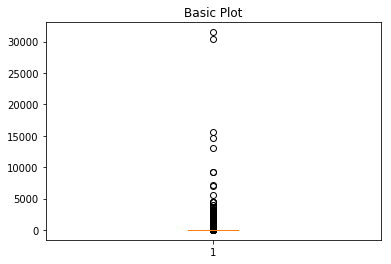

In [101]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(df.duration)

In [94]:
df.head()

,Device ID,End Time,Month,Hour,Day of Week,Year,duration,distance,speed
0,ad14e63b-940d-4ca3-84c6-0131147fba45,06/29/2018 05:30:00 PM,6.0,17.0,5.0,2018.0,6.0,0.6,5.7
1,c5a230c9-7e80-4464-862f-f2b23f61d6d3,11/30/2018 11:00:00 AM,11.0,11.0,5.0,2018.0,3.8,0.5,8.3
2,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,10/02/2018 03:30:00 PM,10.0,15.0,2.0,2018.0,5.4,0.7,8.3
4,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,09/28/2018 11:45:00 AM,9.0,11.0,5.0,2018.0,6.8,0.7,6.3
5,d7f470bf-8f4f-4a07-bed7-1f091014920f,07/22/2018 04:45:00 PM,7.0,16.0,0.0,2018.0,18.2,1.6,5.4


In [69]:
df = pd.read_csv("austin_lite.csv")

In [71]:
dates = df["End Time"]
[dt.datetime.strptime(date, "%m/%d/%Y %I:%M:%S %p").date() for date in dates]
df["date"] = dates
df = df.drop(["End Time"], axis = 1)
df.head()

,Unnamed: 0,Device ID,Month,Hour,Day of Week,Year,duration,distance,date
0,0,ad14e63b-940d-4ca3-84c6-0131147fba45,6.0,17.0,5.0,2018.0,6.0,0.2,06/29/2018 05:30:00 PM
1,1,c5a230c9-7e80-4464-862f-f2b23f61d6d3,11.0,11.0,5.0,2018.0,3.8,0.1,11/30/2018 11:00:00 AM
2,2,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,10.0,15.0,2.0,2018.0,5.4,0.2,10/02/2018 03:30:00 PM
3,3,41fa0cf0-f433-4b3a-89f5-2c6cec6c367d,9.0,16.0,0.0,2018.0,18.3,0.7,09/02/2018 05:00:00 PM
4,4,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,9.0,11.0,5.0,2018.0,6.8,0.3,09/28/2018 11:45:00 AM


In [93]:
dates[0]

'06/29/2018 05:30:00 PM'

In [79]:
# Create Speed Column
df["speed"] = round(60* df["distance"] / df["duration"],1)

# Limit trips 
df = df[df.duration >= 1]
df = df[df.distance >= 0.1]

In [115]:
np.mean(df.speed)

5.586195151422215